<a href="https://colab.research.google.com/github/alessandropequeno/startPhayton/blob/main/deep_q_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medicina Personalizada - Redefinindo o Tratamento de Câncer

In [1]:
# Importando pacotes

import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#import warnings
#warnings.filterwarnings("ignore")

## 1 - Carregando os Dados

### 1.1 - Carregando os dados das informações sobre as mutações genéticas.

In [3]:
# Carregando os dados de treino
df_treino_variantes = pd.read_csv('training_variants.csv')

In [9]:
# Visualizar os dados

df_treino_variantes.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [4]:
# Shape dos dados

df_treino_variantes.shape

(3321, 4)

In [5]:
# Verificando se existem dados missing

df_treino_variantes.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
dtype: int64

### 1.2 - Carregando os dados de evidência (texto) usada para classificar as mutações genéticas

In [6]:
from google.colab import files

uploaded = files.upload()

Saving training_text to training_text


In [7]:
# Carregando os dados de treino

df_treino_texto = pd.read_csv('training_text',
                              sep = '\|\|',
                              engine = 'python',
                              names = ['ID', 'Texto'],
                              skiprows = 1)

In [8]:
# Visualizando os dados

df_treino_texto.head()

,ID,Texto
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [9]:
# Shape dos dados
df_treino_texto.shape

(3321, 2)

In [10]:
# Verificando se existem dados missing
df_treino_texto.isnull().sum()

ID       0
Texto    5
dtype: int64

### 1.3 - Merge dos Arquivos de Dados

In [11]:
# Merge dos arquivos pelo ID
df_treino = pd.merge(df_treino_variantes, df_treino_texto, on = 'ID', how = 'left')


In [12]:
# Visualizando o merge dos dados de treino
df_treino.head()

,ID,Gene,Variation,Class,Texto
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [13]:
# Shape dos dados
df_treino.shape

(3321, 5)

In [14]:
# Verificando se há dados missing após o merge
df_treino.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
Texto        5
dtype: int64

In [15]:
# listando os dados missing (NaN)
df_treino[df_treino.isnull().any(axis = 1)]

,ID,Gene,Variation,Class,Texto
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [16]:
# Tipo das variáveis
df_treino.dtypes

ID            int64
Gene         object
Variation    object
Class         int64
Texto        object
dtype: object

2 - Análise Exploratória dos Dados

In [17]:
# Contando o número de Genes
# Verifica-se que o arquivo contém 264 tipos de Genes
df_treino.Gene.value_counts()


Gene
BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
         ... 
RYBP        1
MDM2        1
CTLA4       1
ARID1A      1
FAM58A      1
Name: count, Length: 264, dtype: int64

In [18]:
# Verificando o total de valores únicos de Genes
df_treino.Gene.nunique()

264

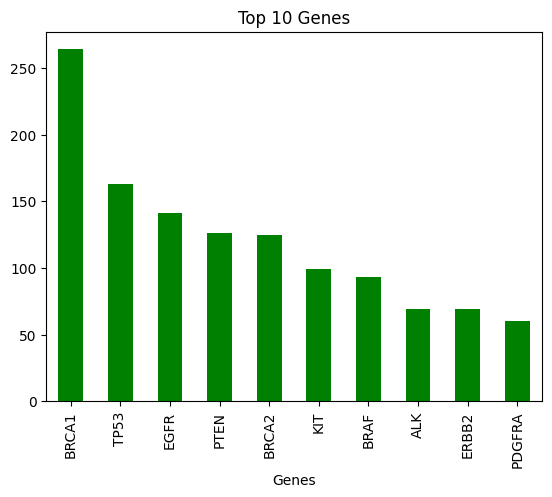

In [19]:
# Gráfico dos top 10 Genes
treino_ten_genes = df_treino['Gene'].value_counts().head(10)

treino_ten_genes.plot(kind = 'bar', color = 'green')
plt.xlabel('Genes')
plt.title('Top 10 Genes')
plt.show()


In [20]:
# Contando o número de variações
# Verifica-se que o arquivo contém 2.996 tipos de variações
df_treino['Variation'].value_counts()


Variation
Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
                        ..
H1094R                   1
M1250T                   1
PTPRZ1-MET Fusion        1
H1106D                   1
K83E                     1
Name: count, Length: 2996, dtype: int64

In [21]:
# Verificando o total de valores únicos de Variation
df_treino.Variation.nunique()


2996

In [22]:
# Contando a quantidade de Class (classificação da mutação genética) por Gene
df_treino.groupby(by = ['Gene'])['Class'].value_counts()


Gene   Class
ABL1   2        24
       7         2
ACVR1  7         2
       2         1
AGO2   1         4
                ..
XPO1   6         1
       2         1
XRCC2  1         2
YAP1   2         3
       7         1
Name: count, Length: 590, dtype: int64

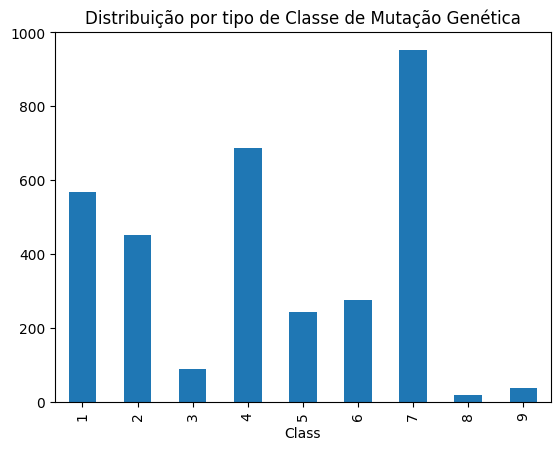

In [23]:
# Gráfico da distribuição de dados por tipo de Class
treino_class = df_treino['Class'].value_counts().sort_index()

treino_class.plot(kind = 'bar')
plt.xlabel('Class')
plt.title('Distribuição por tipo de Classe de Mutação Genética')
plt.show()


###De acordo com o gráfico acima da distribuição de classe, verificamos que a variável Class é desbalanceada (as classes 7, 4, 1 e 2 concentram mais observações do que as demais).

##3 - Pré-Processamento dos Dados

###3.1 - Preparando o Texto (Tokenizantion, Lemmatization, remoção de Pontuação e Stopwords)

In [24]:
# Importando pacotes de PLN (Processamento de Linguagem Natural)

import re
import nltk
import spacy
import string
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from keras.utils.np_utils import to_categorical
from datetime import datetime

import warnings
warnings.filterwarnings(action = "ignore", category = FutureWarning)
# warnings.filterwarnings("ignore", category = DeprecationWarning)

In [25]:
# Converte Texto para o tipo string
df_treino['Texto'] = df_treino['Texto'].astype('str')

In [26]:
# Função para remover caracteres non-ascii
def removeNoAscii(s):
    return "".join(i for i in s if ord(i) < 128)

In [27]:
# Remove caracteres non-ascii
df_treino['Texto'] = df_treino['Texto'].map(lambda x: removeNoAscii(x))

In [28]:
# Carrega o dicionário em Inglês na sessão SpaCy
nlp = spacy.load('en_core_web_sm')

In [29]:
# Função para remover pontuação e lematizar
def limpa_texto(text):

    # Remove pontuação usando expressão regular
    regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
    nopunct = regex.sub(" ", str(text))

    # Usa o SpaCy para lematização
    doc = nlp(nopunct, disable = ['parser', 'ner'])
    lemma = [token.lemma_ for token in doc]
    return lemma

In [30]:
# Aplica a função
start = datetime.now()
df_treino['Texto'] = df_treino['Texto'].map(limpa_texto)
print('Tempo Total para Limpar o Texto :', datetime.now() - start)


Tempo Total para Limpar o Texto : 0:55:42.562792


In [31]:
# Transforma o Texto em minúsculo
df_treino['Texto'] = df_treino['Texto'].map(lambda x: [word.lower() for word in x])


In [32]:
df_treino.head()

,ID,Gene,Variation,Class,Texto
0,0,FAM58A,Truncating Mutations,1,"[cyclin, dependent, kinase, , cdk, , regulat..."
1,1,CBL,W802*,2,"[ , abstract, background, , non, small, cell,..."
2,2,CBL,Q249E,2,"[ , abstract, background, , non, small, cell,..."
3,3,CBL,N454D,3,"[recent, evidence, have, demonstrate, that, ac..."
4,4,CBL,L399V,4,"[oncogenic, mutation, in, the, monomeric, casi..."


In [33]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [34]:
# Função para remover stopwords
english_stops = set(stopwords.words('english'))

def remove_stopwords(text):
    return [word for word in text if word not in english_stops]

In [35]:
# Aplica a função para remover stopwords do texto
df_treino['Texto'] = df_treino['Texto'].map(lambda x: remove_stopwords(x))


In [36]:
df_treino.head()


,ID,Gene,Variation,Class,Texto
0,0,FAM58A,Truncating Mutations,1,"[cyclin, dependent, kinase, , cdk, , regulat..."
1,1,CBL,W802*,2,"[ , abstract, background, , non, small, cell,..."
2,2,CBL,Q249E,2,"[ , abstract, background, , non, small, cell,..."
3,3,CBL,N454D,3,"[recent, evidence, demonstrate, acquire, unipa..."
4,4,CBL,L399V,4,"[oncogenic, mutation, monomeric, casitas, b, l..."


In [37]:
# Função para remover espaços em branco
def remove_espaco(text):
    return [word for word in text if word != " "]

In [38]:
# Aplica a função para remover espaços em branco do texto
df_treino['Texto'] = df_treino['Texto'].map(lambda x: remove_espaco(x))


In [39]:
df_treino.head()

,ID,Gene,Variation,Class,Texto
0,0,FAM58A,Truncating Mutations,1,"[cyclin, dependent, kinase, cdk, regulate, var..."
1,1,CBL,W802*,2,"[abstract, background, non, small, cell, lung,..."
2,2,CBL,Q249E,2,"[abstract, background, non, small, cell, lung,..."
3,3,CBL,N454D,3,"[recent, evidence, demonstrate, acquire, unipa..."
4,4,CBL,L399V,4,"[oncogenic, mutation, monomeric, casitas, b, l..."


In [40]:
# Converte a lista de Texto para string
df_treino['Texto'] = df_treino['Texto'].astype(str)


In [41]:
df_treino.head()

,ID,Gene,Variation,Class,Texto
0,0,FAM58A,Truncating Mutations,1,"['cyclin', 'dependent', 'kinase', 'cdk', 'regu..."
1,1,CBL,W802*,2,"['abstract', 'background', 'non', 'small', 'ce..."
2,2,CBL,Q249E,2,"['abstract', 'background', 'non', 'small', 'ce..."
3,3,CBL,N454D,3,"['recent', 'evidence', 'demonstrate', 'acquire..."
4,4,CBL,L399V,4,"['oncogenic', 'mutation', 'monomeric', 'casita..."


In [42]:
# Join das variáveis preditoras
df_treino['GenVarText'] = df_treino[['Gene', 'Variation','Texto']].apply(lambda x: " ".join(x), axis=1)


In [43]:
# Cria objeto tokenizer
num_max_words = 2000
tokenizer = Tokenizer(num_words = num_max_words)


In [44]:
df_treino.head()

,ID,Gene,Variation,Class,Texto,GenVarText
0,0,FAM58A,Truncating Mutations,1,"['cyclin', 'dependent', 'kinase', 'cdk', 'regu...","FAM58A Truncating Mutations ['cyclin', 'depend..."
1,1,CBL,W802*,2,"['abstract', 'background', 'non', 'small', 'ce...","CBL W802* ['abstract', 'background', 'non', 's..."
2,2,CBL,Q249E,2,"['abstract', 'background', 'non', 'small', 'ce...","CBL Q249E ['abstract', 'background', 'non', 's..."
3,3,CBL,N454D,3,"['recent', 'evidence', 'demonstrate', 'acquire...","CBL N454D ['recent', 'evidence', 'demonstrate'..."
4,4,CBL,L399V,4,"['oncogenic', 'mutation', 'monomeric', 'casita...","CBL L399V ['oncogenic', 'mutation', 'monomeric..."


In [45]:
# Conferindo se ainda há valores missing
df_treino['GenVarText'].isnull().any()


False

In [46]:
# Tokenizer
tokenizer.fit_on_texts(df_treino['GenVarText'].values)


In [47]:
# Converte para sequência
sequencia_treino = tokenizer.texts_to_sequences(df_treino['GenVarText'].values)


In [48]:
# Preenche a sequência
X = pad_sequences(sequencia_treino, maxlen = num_max_words)

In [49]:
X.shape

(3321, 2000)

###3.2 - Divisão dos Dados em Treino e Teste

In [50]:
# Importando módulo do SKlearn
from sklearn.model_selection import train_test_split

In [51]:
# Cria variável dummy target (Class)
y = pd.get_dummies(df_treino['Class']).values


In [52]:
y.shape

(3321, 9)

In [53]:
# Dividindo os dados em treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.1, shuffle = True, random_state = 5)


In [54]:
# Shape dos dados de treino
print(X_treino.shape)
print(y_treino.shape)


(2988, 2000)
(2988, 9)


In [55]:
# Shape dos dados de teste
print(X_teste.shape)
print(y_teste.shape)

(333, 2000)
(333, 9)


##4 - Construção de Modelo de Deep Learning

In [56]:
import keras
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Dropout, LSTM, SpatialDropout1D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

import warnings
# warnings.filterwarnings("ignore")
warnings.filterwarnings(action = "ignore", category = FutureWarning)
warnings.filterwarnings(action = "ignore", category = DeprecationWarning)



###Modelo de Rede Neural LSTM (Long Short Term Memory)

In [57]:
# Modelo LSTM

# Cria o objeto sequencial
modelo_lstm = Sequential()

# Primeira camada para receber os dados de entrada
modelo_lstm.add(Embedding(input_dim = num_max_words, output_dim = 128, input_length = X.shape[1]))
modelo_lstm.add(SpatialDropout1D(0.3))

# Segunda camada de LSTM
modelo_lstm.add(LSTM(196, dropout = 0.3, recurrent_dropout = 0.3))

# Terceira camada oculta com ativação ReLu
modelo_lstm.add(Dense(196, activation = 'relu'))

# Dropout para evitar Overfitting
modelo_lstm.add(Dropout(0.3))

# Última camada com ativação Softmax
modelo_lstm.add(Dense(9, activation = 'softmax'))

print(modelo_lstm.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 128)         256000    
                                                                 
 spatial_dropout1d (Spatial  (None, 2000, 128)         0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 196)               38612     
                                                                 
 dropout (Dropout)           (None, 196)               0         
                                                                 
 dense_1 (Dense)             (None, 9)                 1773      
                                                        

In [58]:
# Compilando o modelo com a função de perda de entropia cruzada, otimizador Adam (utiliza o gradiente descendente)
# e a métrica acurácia.

modelo_lstm.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [59]:
# Salvando modelo callback
ckpt_callback = ModelCheckpoint('keras_model',
                                 monitor='val_acc',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='max')

In [60]:
# Hiperparâmetros
epochs = 8
batch_size = 32

###O treinamento ocorre através de épocas (epochs) e cada época é dividida em lotes (batch), onde uma época é uma passagem por todas as linhas do conjunto de dados de treinamento e um lote é composto de uma ou mais amostras consideradas pelo modelo em uma época antes que seja feita a atualização dos pesos.

In [61]:
# Teinamento do modelo LSTM, reservando 20% dos dados para validação
start = datetime.now()
history1 = modelo_lstm.fit(X_treino, y_treino, validation_split = 0.2, epochs = epochs, batch_size = batch_size,  callbacks=[ckpt_callback], metrics=['acc'])
print('Tempo Total de Treinamento :', datetime.now() - start)

Epoch 1/8
75/75 [==============================] - ETA: 0s - loss: 1.8863 - accuracy: 0.2766 

75/75 [==============================] - 995s 13s/step - loss: 1.8863 - accuracy: 0.2766 - val_loss: 1.7015 - val_accuracy: 0.4164
Epoch 2/8
75/75 [==============================] - ETA: 0s - loss: 1.4373 - accuracy: 0.4858 

75/75 [==============================] - 993s 13s/step - loss: 1.4373 - accuracy: 0.4858 - val_loss: 1.3744 - val_accuracy: 0.5017
Epoch 3/8
75/75 [==============================] - ETA: 0s - loss: 1.1802 - accuracy: 0.5577 

75/75 [==============================] - 995s 13s/step - loss: 1.1802 - accuracy: 0.5577 - val_loss: 1.3114 - val_accuracy: 0.5284
Epoch 4/8
75/75 [==============================] - ETA: 0s - loss: 1.0454 - accuracy: 0.6134 

75/75 [==============================] - 974s 13s/step - loss: 1.0454 - accuracy: 0.6134 - val_loss: 1.2887 - val_accuracy: 0.5619
Epoch 5/8
75/75 [==============================] - ETA: 0s - loss: 0.9276 - accuracy: 0.6603 

75/75 [==============================] - 975s 13s/step - loss: 0.9276 - accuracy: 0.6603 - val_loss: 1.3280 - val_accuracy: 0.5435
Epoch 6/8
75/75 [==============================] - ETA: 0s - loss: 0.8802 - accuracy: 0.6858 

75/75 [==============================] - 986s 13s/step - loss: 0.8802 - accuracy: 0.6858 - val_loss: 1.3390 - val_accuracy: 0.5485
Epoch 7/8
75/75 [==============================] - ETA: 0s - loss: 0.8201 - accuracy: 0.7100 

75/75 [==============================] - 986s 13s/step - loss: 0.8201 - accuracy: 0.7100 - val_loss: 1.3745 - val_accuracy: 0.5602
Epoch 8/8
75/75 [==============================] - ETA: 0s - loss: 0.7555 - accuracy: 0.7381 

75/75 [==============================] - 986s 13s/step - loss: 0.7555 - accuracy: 0.7381 - val_loss: 1.3638 - val_accuracy: 0.6087
Tempo Total de Treinamento : 2:12:28.965011


In [89]:
print('Loss em validação:', history1.history['val_loss'][-1])
print('Acurácia em validação:', history1.history['val_accuracy'][-1])


Loss em validação: 1.3638373613357544
Acurácia em validação: 0.6086956262588501


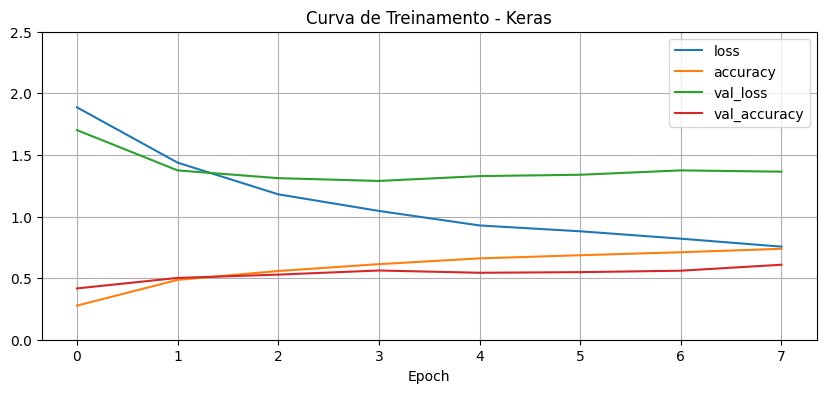

In [63]:
# Plot do histórico de treinamento - Loss e Accuracy
pd.DataFrame(history1.history).plot(figsize = (10, 4))
plt.grid(True)
plt.gca().set_ylim(0, 2.5)
plt.title("Curva de Treinamento - Keras")
plt.xlabel("Epoch")
plt.show()


##5 - Previsão com Dados de Teste

In [70]:
!pip install scikit-plot

In [71]:
import scikitplot.plotters as skplt


In [65]:
# Avaliação da previsão do modelo para os dados de teste
score = modelo_lstm.evaluate(X_teste, y_teste, verbose = 1)

print('Loss:', score[0])
print('Acurácia:', score[1])

11/11 [==============================] - 17s 1s/step - loss: 1.3423 - accuracy: 0.5495
Loss: 1.3423314094543457
Acurácia: 0.5495495200157166


In [77]:
# Previsões com dados de teste
y_pred = modelo_lstm.predict(X_teste)


11/11 [==============================] - 16s 2s/step


In [80]:
# Prever as probabilidades para a variável Class
y_prob = modelo_lstm.predict(X_teste)  # Obter as probabilidades previstas

11/11 [==============================] - 17s 2s/step


In [81]:
pred_indices = np.argmax(y_pred, axis=1)
classes = np.array(range(1, 10))
preds = classes[pred_indices]


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

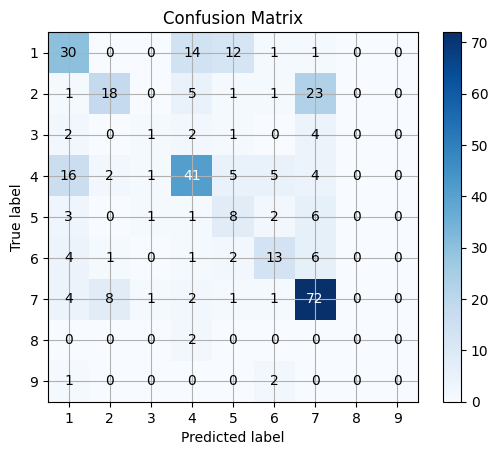

In [82]:
# Confusion Matrix
skplt.plot_confusion_matrix(classes[np.argmax(y_teste, axis=1)], preds)


#Conclusão:

##Verifica-se na diagonal da matriz, acima, que as classes com mais observações (classes 7, 4, 1 e 2) foram as que apresentaram maiores acertos na previsão. Para melhorar a precisão do modelo teríamos que obter mais dados das demais classes.

In [83]:
# Visualizando as probabilidades das classes para os 10 primeiros registros
pred = pd.DataFrame(y_prob)
pred.columns = ['Class1', 'Class2', 'Class3', 'Class4', 'Class5', 'Class6', 'Class7', 'Class8', 'Class9']
pred.head(10)


,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9
0,0.030447,0.050757,0.085882,0.049855,0.085107,0.326041,0.074219,0.049804,2.478885e-01
1,0.811286,0.021320,0.002298,0.039162,0.043894,0.020453,0.059660,0.001018,9.081330e-04
2,0.001675,0.175104,0.000941,0.001553,0.007443,0.002298,0.810811,0.000129,4.698032e-05
3,0.004549,0.053070,0.364107,0.023163,0.059953,0.061943,0.280944,0.022158,1.301130e-01
4,0.052391,0.076247,0.017940,0.007869,0.409963,0.055946,0.362921,0.008309,8.413787e-03
5,0.000161,0.005510,0.000023,0.000037,0.000612,0.000041,0.993616,0.000001,1.643498e-07
6,0.003063,0.002611,0.091201,0.058612,0.024261,0.754571,0.006444,0.004230,5.500542e-02
7,0.002307,0.112150,0.003301,0.002149,0.015212,0.003216,0.861085,0.000398,1.806629e-04
8,0.001078,0.826665,0.016770,0.006695,0.015208,0.013119,0.116235,0.001645,2.584762e-03
9,0.198823,0.220428,0.033684,0.124946,0.075048,0.130320,0.171391,0.024094,2.126684e-02
